# Notebook 5 - Building ML models for the windfarm dataset

Now let's get cracking. Here we will build different models, just as we have done for the first dataset. We will also try to learn something about the dataset.

In [117]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD, Adam

In [13]:
DATADIR = './dataset2/'

In [189]:
with open('./tmp/wind_ds_clean.pkl', 'rb') as f:
    X_train, Xobs_train, y_train, X_valid, Xobs_valid, y_valid, X_test, Xobs_test = pickle.load(f)

In [190]:
with open('./tmp/test_times.pkl', 'rb') as f:
    test_times = pickle.load(f)

In [191]:
X_train.shape, Xobs_train.shape, y_train.shape, X_valid.shape

((2507, 210), (2507, 24), (2507, 33), (199, 210))

In [66]:
def mse(y_true, y_pred, axis=(0,1)): return ((y_true - y_pred)**2).mean(axis)
def rmse(y_true, y_pred, axis=(0,1)): return np.sqrt(((y_true - y_pred)**2).mean(axis))
def create_sub(preds, fn=None):
    """Sorry for the complicated submission format. But just use this function """
    time_string = [
        f'{str(tt)[:13]}+{str(lt).zfill(2)}h' for tt, lt 
        in zip(np.repeat(test_times, 33), np.tile(np.arange(0, 33*3,3), len(test_times)))]
    df =  pd.DataFrame({'Time': time_string, 'Expected': np.ravel(preds)})
    if fn is not None: df.to_csv(DATADIR + fn, index=False)
    return df

## Linear regression

Let's start out again with a simple linear regression model. It is always good to start with the dumbest model possible to create a benchmark.

### Normalize the dataset

Recall that for linear regression and neural networks we need to normalize our input data.

In [74]:
# Remember to use the same mean and std for all datasets
mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

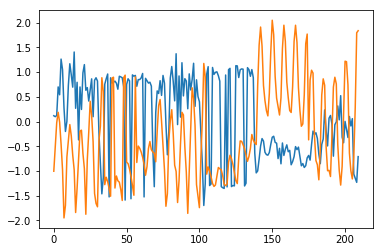

In [75]:
plt.plot(X_train[-1])
plt.plot(X_valid[0])

### Train the model

Now we proceed as before.

In [204]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [205]:
def print_scores(m, X_train=X_train, X_valid=X_valid):
    print('Train R2 = ', m.score(X_train, y_train), 
          ', Valid R2 = ', m.score(X_valid, y_valid), ', Valid RMSE = ', 
          rmse(m.predict(X_valid), y_valid))

In [206]:
print_scores(lr)

Train R2 =  0.5513175404570548 , Valid R2 =  0.4438299964505213 , Valid RMSE =  0.16551983


### Check the prediction against lead time

In [207]:
def plot_rmse_lead(y_true, y_pred, label=None):
    plt.plot(np.arange(0, y_true.shape[1]*3, 3), rmse(y_true, y_pred, 0), label=label)
    plt.xlabel('Lead time'); plt.ylabel('RMSE'); 
    if label is not None: plt.legend()

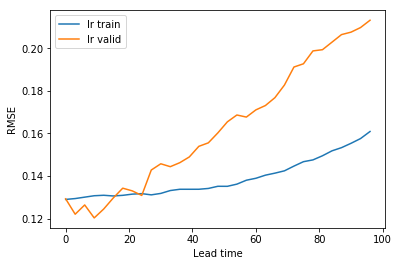

In [208]:
plot_rmse_lead(y_train, lr.predict(X_train), 'lr train')
plot_rmse_lead(y_valid, lr.predict(X_valid), 'lr valid')

We can see that the error goes up with time, just as we would expect.

### Create submission

In [81]:
df = create_sub(lr.predict(X_test), 'lr.csv')

In [82]:
df.head()

,Time,Expected
0,2015-03-01T00+00h,0.151643
1,2015-03-01T00+03h,0.072004
2,2015-03-01T00+06h,-0.012968
3,2015-03-01T00+09h,0.064582
4,2015-03-01T00+12h,0.159778


## Random forest

We already know that we can probably do better with a random forest. Se let's simply try our setting from the previous notebook.

In [83]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [84]:
%time rf.fit(X_train, y_train)

CPU times: user 26.7 s, sys: 12 ms, total: 26.7 s
Wall time: 1.54 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [85]:
print_scores(rf)

Train R2 =  0.5553974423356878 , Valid R2 =  0.38283811705658094 , Valid RMSE =  0.1743595820229323


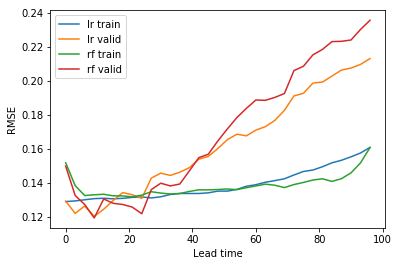

In [86]:
plot_rmse_lead(y_train, lr.predict(X_train), 'lr train')
plot_rmse_lead(y_valid, lr.predict(X_valid), 'lr valid')
plot_rmse_lead(y_train, rf.predict(X_train), 'rf train')
plot_rmse_lead(y_valid, rf.predict(X_valid), 'rf valid')

Well, that is not very good. Even the training score is not better than for linear regression. This tells us that there is some underfitting going on. Let's try to increase the complexity of the forest.

### A more complex forest?

In [105]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=5)

In [106]:
%time rf.fit(X_train, y_train)

CPU times: user 34.7 s, sys: 24 ms, total: 34.7 s
Wall time: 2.04 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [107]:
print_scores(rf)

Train R2 =  0.6573039248566966 , Valid R2 =  0.3941184591176736 , Valid RMSE =  0.17275878148078155


That's a little better. But even after trying a range of parameter combinations I was not able to beat the linear regression score. Hmmm?

In [57]:
df = create_sub(rf.predict(X_test), 'rf.csv')

As you can see, real machine learning problems are hard and a lot of the time is spent on wondering what the hell is going on. 

## Neural networks in sklearn

Ok, so now let's start with a neural network. At first, let's actually try something different and use the sklearn MLP class. It's very unflexible but has some good defaults for simple problems like ours.

In [108]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=200)

In [109]:
y_train

array([[0.46821818, 0.18040869, 0.15520217, ..., 0.00050652, 0.02535435,
        0.17103262],
       [0.18040869, 0.15520217, 0.00940435, ..., 0.02535435, 0.17103262,
        0.11740869],
       [0.15520217, 0.00940435, 0.00260217, ..., 0.17103262, 0.11740869,
        0.        ],
       ...,
       [0.13816522, 0.16569318, 0.00960652, ..., 0.        , 0.00171957,
        0.        ],
       [0.16569318, 0.00960652, 0.00628261, ..., 0.00171957, 0.        ,
        0.05184546],
       [0.00960652, 0.00628261, 0.18051429, ..., 0.        , 0.05184546,
        0.33955002]], dtype=float32)

In [110]:
%time nn.fit(X_train, y_train)

CPU times: user 11.1 s, sys: 176 ms, total: 11.3 s
Wall time: 1.13 s


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[32, 32], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [111]:
print_scores(nn)

Train R2 =  0.4632325728448572 , Valid R2 =  0.35400881068940093 , Valid RMSE =  0.17838550775877374


I noticed something interesting when trying out the NN above.

In [132]:
train_scores, valid_scores = [], []
train_rmses, valid_rmses = [], []
nns = []
for i in range(20):
    nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=200)
    nn.fit(X_train, y_train)
    train_scores.append(nn.score(X_train, y_train)); valid_scores.append(nn.score(X_valid, y_valid))
    train_rmses.append(rmse(nn.predict(X_train), y_train)); valid_rmses.append(rmse(nn.predict(X_valid), y_valid))
    nns.append(nn)

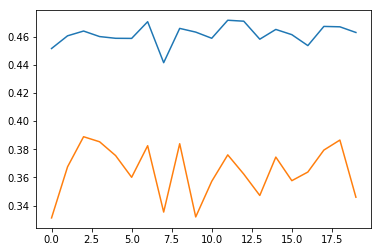

In [113]:
plt.plot(train_scores)
plt.plot(valid_scores)

Neural networks are stochastic! As we can see, the validation score fluctuates quite drastically. This also has to do with our small validation set size. 

One way to combat such fluctuations is by creating an ensemble.

In [135]:
ensemble_preds = [nn.predict(X_valid) for nn in nns]

In [136]:
ensemble_preds = np.array(ensemble_preds); ensemble_preds.shape

(20, 199, 33)

In [137]:
r2_score(y_valid, ensemble_preds.mean(0)), rmse(y_valid, ensemble_preds.mean(0))

(0.47201479670045876, 0.16402420821823865)

In [138]:
np.mean(valid_scores), np.mean(valid_rmses)

(0.367841066034033, 0.17645620980566545)

Again, we see something quite weird. The R2 score for the ensemble mean predictions went up drastically, but the RMSE only by a little bit.

Another thing to pay attention to when doing ML: the metric. What do you actually want from the dataset?

## Now with Keras

In [175]:
nn = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dense(y_train.shape[1], activation='linear')
])

In [176]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                6752      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 33)                1089      
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [177]:
nn.compile(Adam(1e-3), 'mse')

In [178]:
h = nn.fit(X_train, y_train, 1024, epochs=3000, validation_data=(X_valid, y_valid), verbose=0)

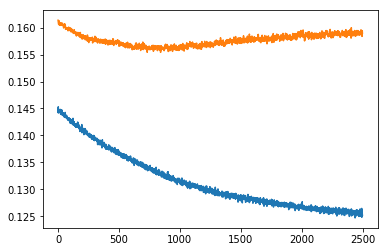

In [182]:
plt.plot(np.sqrt(h.history['loss'][500:]))
plt.plot(np.sqrt(h.history['val_loss'][500:]))
#plt.yscale('log')

In [180]:
rmse(y_valid, nn.predict(X_valid, 10000))

0.15895139

### Early stopping

From the figure above we can see that the validation score reaches a minimum. Ideally we would like to stop then.

In [183]:
from keras.callbacks import EarlyStopping

In [184]:
es = EarlyStopping(patience=200)

In [185]:
nn = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dense(y_train.shape[1], activation='linear')
])
nn.compile(Adam(1e-3), 'mse')

In [186]:
h = nn.fit(X_train, y_train, 1024, epochs=3000, validation_data=(X_valid, y_valid), verbose=0, callbacks=[es])

In [187]:
rmse(y_valid, nn.predict(X_valid, 10000))

0.15597911

In [188]:
df = create_sub(nn.predict(X_test, 10000), 'nn_es.csv')

## Add recent observation data

In [192]:
mean, std = Xobs_train.mean(0), Xobs_train.std(0)
Xobs_train = (Xobs_train - mean) / std
Xobs_valid = (Xobs_valid - mean) / std
Xobs_test = (Xobs_test - mean) / std

In [198]:
np.isnan(Xobs_train).sum()

5014

In [193]:
X_train.shape, Xobs_train.shape

((2507, 210), (2507, 24))

In [199]:
Xobs_train[np.isnan(Xobs_train)] = np.nanmean(Xobs_train)
Xobs_valid[np.isnan(Xobs_valid)] = np.nanmean(Xobs_train)
Xobs_test[np.isnan(Xobs_test)] = np.nanmean(Xobs_train)

In [200]:
Xconcat_train = np.hstack([X_train, Xobs_train])
Xconcat_valid = np.hstack([X_valid, Xobs_valid])
Xconcat_test = np.hstack([X_test, Xobs_test])

In [209]:
lr_obs = LinearRegression()
lr_obs.fit(Xconcat_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [210]:
print_scores(lr_obs, Xconcat_train, Xconcat_valid)

Train R2 =  0.5844313282686324 , Valid R2 =  0.46287938500419035 , Valid RMSE =  0.16266052


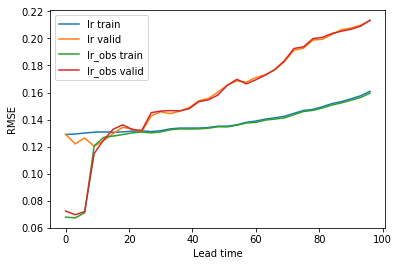

In [211]:
plot_rmse_lead(y_train, lr.predict(X_train), 'lr train')
plot_rmse_lead(y_valid, lr.predict(X_valid), 'lr valid')
plot_rmse_lead(y_train, lr_obs.predict(Xconcat_train), 'lr_obs train')
plot_rmse_lead(y_valid, lr_obs.predict(Xconcat_valid), 'lr_obs valid')

## Your turn

- Try to get the best score possible. As you will have noticed, I am not really able to give you many tips, so be creative and try a lot of things out!
- Use the observation data for a neural network.
- You could for example play around with early stopping, ensembles and dropout. Or combine different types of models in an ensemble.